In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as np
import tomllib

%matplotlib inline

In [2]:
from burst import kl_divergence_filter, load_basis
from utils import make_plots

In [3]:
prng_key = jax.random.PRNGKey(10)

config = tomllib.load(open("sinegaussian_selection.toml", "rb"))

bounds = config["bounds"]
duration = config["duration"]
sample_rate = config["sample_rate"]

In [4]:
basis, weights = load_basis("sinegaussian_svd_250502.pkl", truncation=config["truncation"])

Running 0.3_2.3
Loading data from data_0.3_2.3.pkl
Signals loaded, with shape (1344, 20)


  0%|          | 0/110 [00:00<?, ?it/s]

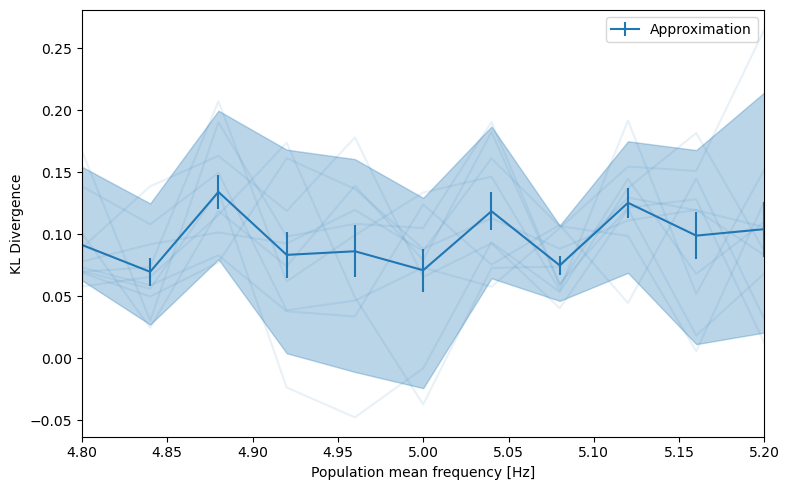

Running 0.4_2.3
Loading data from data_0.4_2.3.pkl
Signals loaded, with shape (1282, 20)


  0%|          | 0/110 [00:00<?, ?it/s]

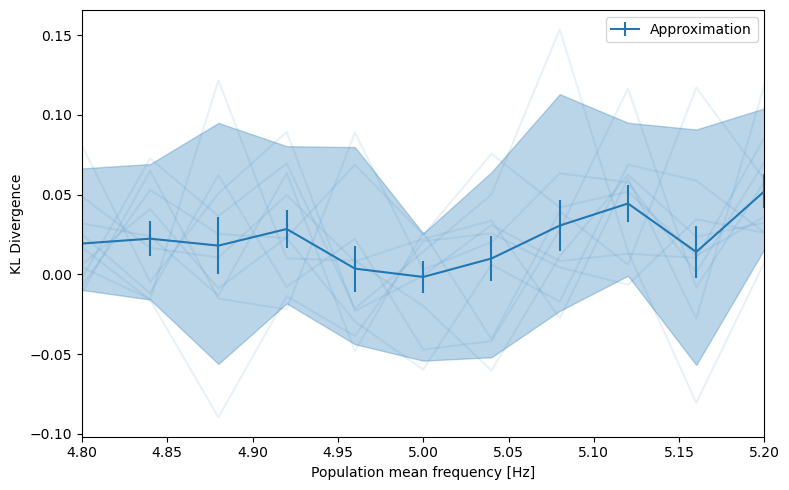

Running 0.6_2.3
Loading data from data_0.6_2.3.pkl
Signals loaded, with shape (1261, 20)


  0%|          | 0/110 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
simulate_kwargs = dict(
    basis=basis,
    weights=weights,
    bounds=bounds,
    duration=duration,
    sample_rate=sample_rate,
    time_align=True,
)

# sigma_pop = config["configurations"]["sigma"][0]
# snr_threshold = config["configurations"]["threshold"][0]
# sigma_pop = 0.35
# snr_threshold = 0
for (sigma_pop, snr_threshold) in zip(
    config["configurations"]["sigma"], config["configurations"]["threshold"]
):
# for _ in range(5):
    label = f"{sigma_pop}_{snr_threshold}"
    # if label != "0.8_11":
    #     continue
    # if sigma_pop > 0.5:
    #     continue

    print(f"Running {label}")

    all_divs = list()
    simulation_kwargs = dict(
        sigma_frequency=sigma_pop,
        # ntrials=config["simulations"]["n_trials"],
        ntrials=10,
        population_size=config["simulate"]["n_events"] * (1 + (snr_threshold > 0)),
        threshold=snr_threshold,
        fpeaks=np.linspace(4.8, 5.2, 11),
        **simulate_kwargs,
    )

    for _ in range(1):
        prng_key, subkey = jax.random.split(prng_key)
        ln_ls = kl_divergence_filter(subkey, **simulation_kwargs)
        all_divs.append(ln_ls)
    np.save(f"kl_divs_{label}.npy", np.array(all_divs))

    make_plots(np.linspace(*config["frequency_evaluation_bounds"], config["plot_points"]), *all_divs)


Running 0.3_8
Loading data from data_0.3_8.pkl
Signals loaded, with shape (3012, 40)


  0%|          | 0/1650 [00:00<?, ?it/s]

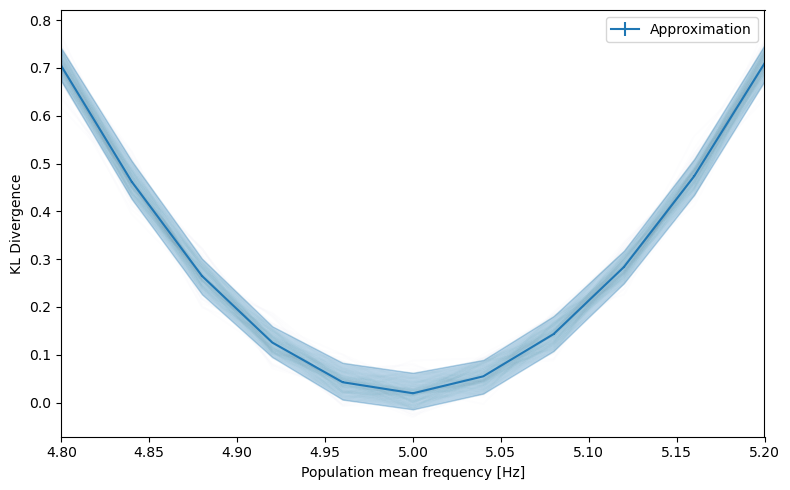

Running 0.4_8
Loading data from data_0.4_8.pkl
Signals loaded, with shape (2930, 40)


  0%|          | 0/1650 [00:00<?, ?it/s]

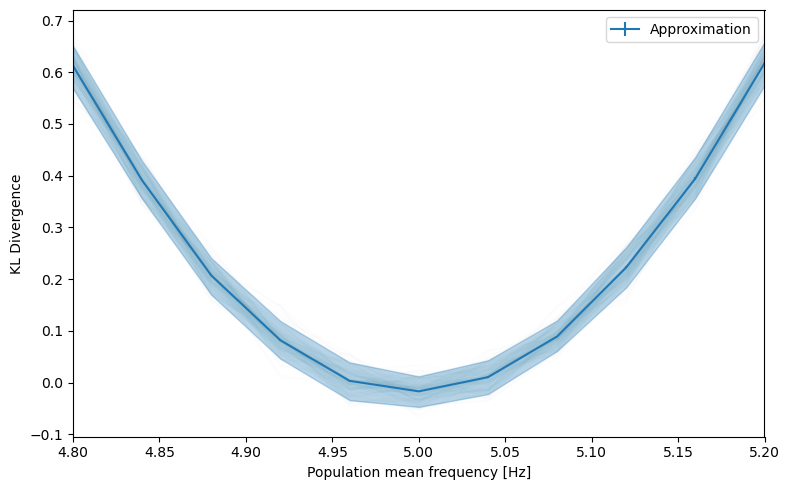

Running 0.6_8
Loading data from data_0.6_8.pkl
Signals loaded, with shape (2931, 40)


  0%|          | 0/1650 [00:00<?, ?it/s]

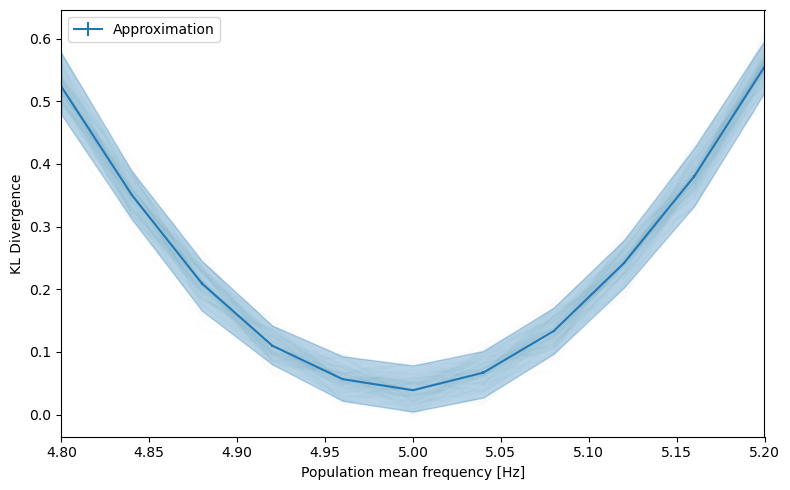

Running 0.8_8
Loading data from data_0.8_8.pkl
Signals loaded, with shape (2941, 40)


  0%|          | 0/1650 [00:00<?, ?it/s]

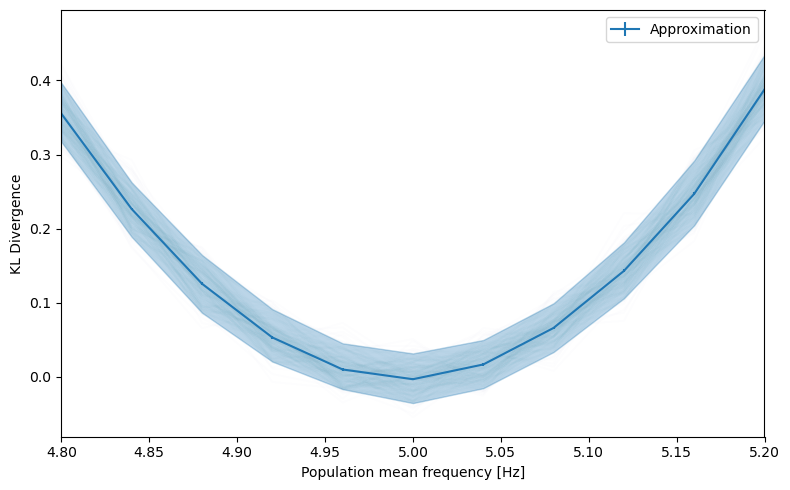

Running 0.35_0
Loading data from data_0.35_0.pkl
Signals loaded, with shape (3000, 40)


  0%|          | 0/1650 [00:00<?, ?it/s]

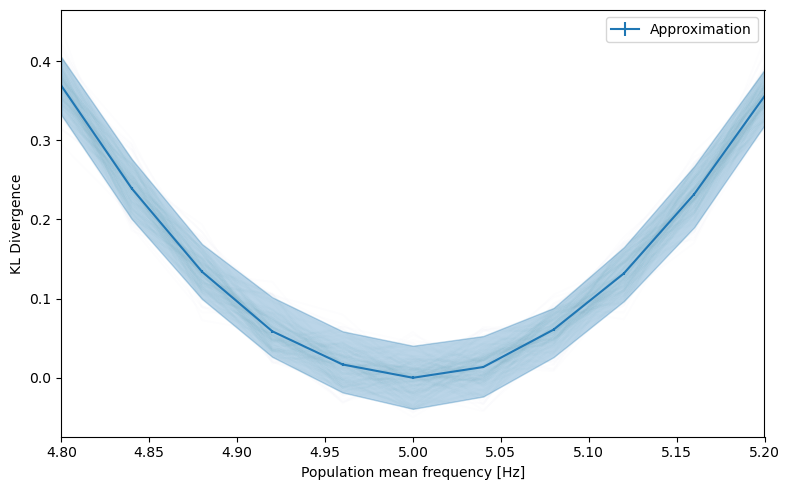

Running 0.45_0
Loading data from data_0.45_0.pkl
Signals loaded, with shape (3000, 40)


  0%|          | 0/1650 [00:00<?, ?it/s]

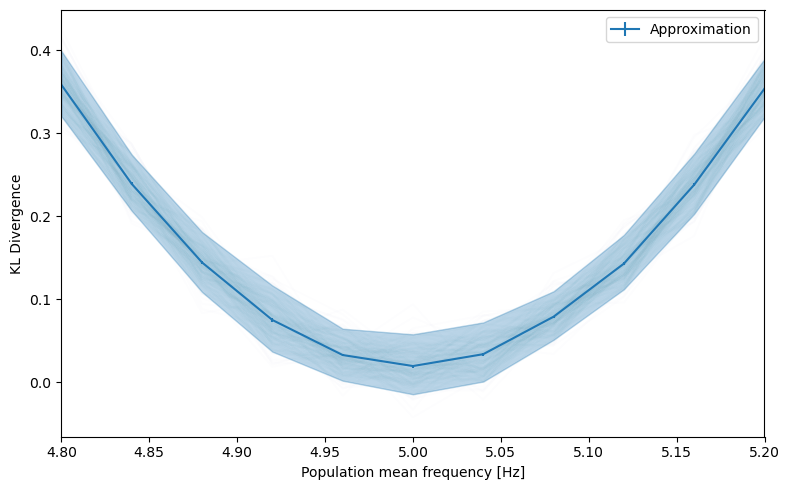

Running 0.65_0
Loading data from data_0.65_0.pkl
Signals loaded, with shape (3000, 40)


  0%|          | 0/1650 [00:00<?, ?it/s]

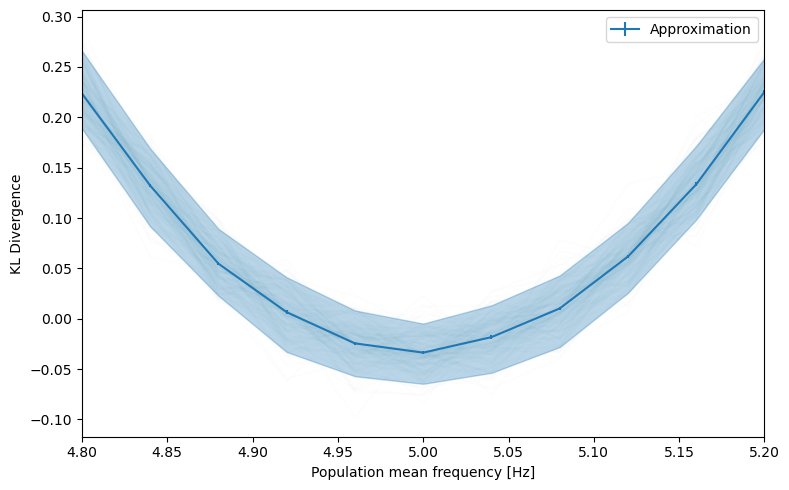

Running 0.85_0
Loading data from data_0.85_0.pkl
Signals loaded, with shape (3000, 40)


  0%|          | 0/1650 [00:00<?, ?it/s]

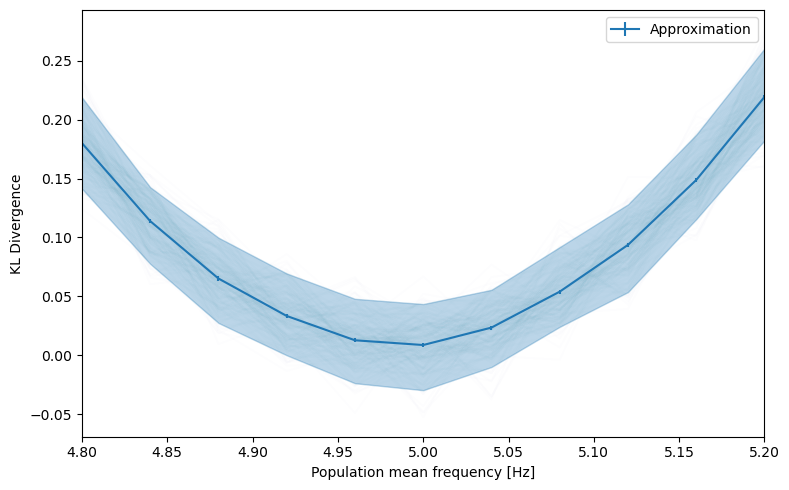

In [ ]:
simulate_kwargs = dict(
    basis=basis,
    projection=projection,
    bounds=bounds,
    duration=duration,
    sample_rate=sample_rate,
    time_align=True,
)

for (sigma_pop, snr_threshold) in zip(
    config["configurations"]["sigma"], config["configurations"]["threshold"]
):
    label = f"{sigma_pop}_{snr_threshold}"

    print(f"Running {label}")

    all_divs = list()
    simulation_kwargs = dict(
        sigma_frequency=sigma_pop,
        ntrials=config["simulations"]["n_trials"],
        population_size=config["simulate"]["n_events"] * (1 + (snr_threshold > 0)),
        threshold=snr_threshold,
        **simulate_kwargs,
    )

    for _ in range(1):
        prng_key, subkey = jax.random.split(prng_key)
        ln_ls = kl_divergence_filter(subkey, **simulation_kwargs)
        all_divs.append(ln_ls)
    np.save(f"kl_divs_{label}.npy", np.array(all_divs))

    make_plots(np.linspace(*config["frequency_evaluation_bounds"], config["plot_points"]), *all_divs)


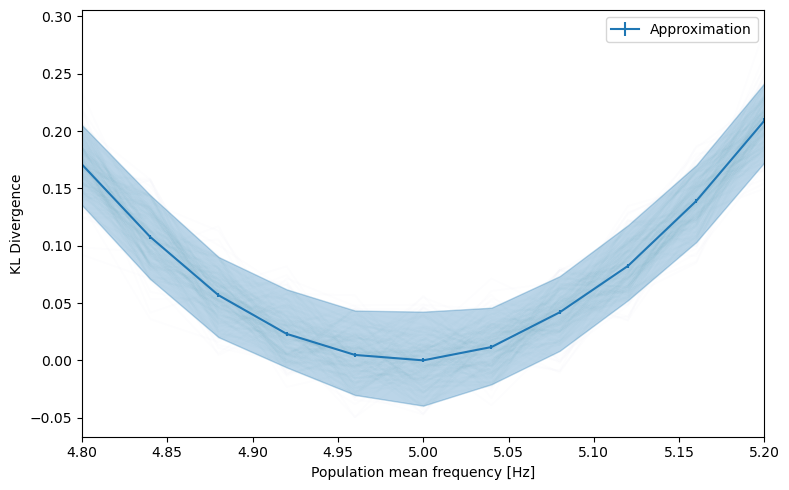

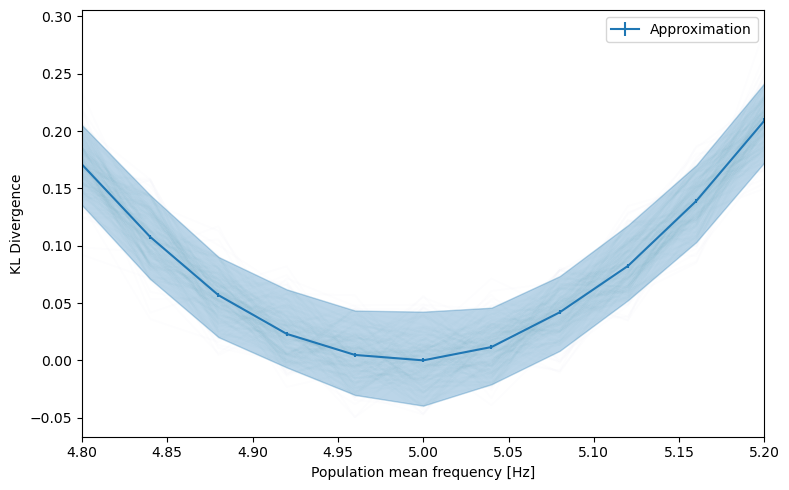

In [10]:
# make_plots(np.linspace(4.8, 5.2, 11), *all_divs[1:])
scaled = np.array(all_divs) - np.min(np.mean(np.array(all_divs), axis=-1), axis=-1)[:, None, None]
# scaled *= 4 / 5
# scaled *= 1 / 2
# scaled *= 5 / 4
make_plots(np.linspace(4.8, 5.2, 11), *scaled)

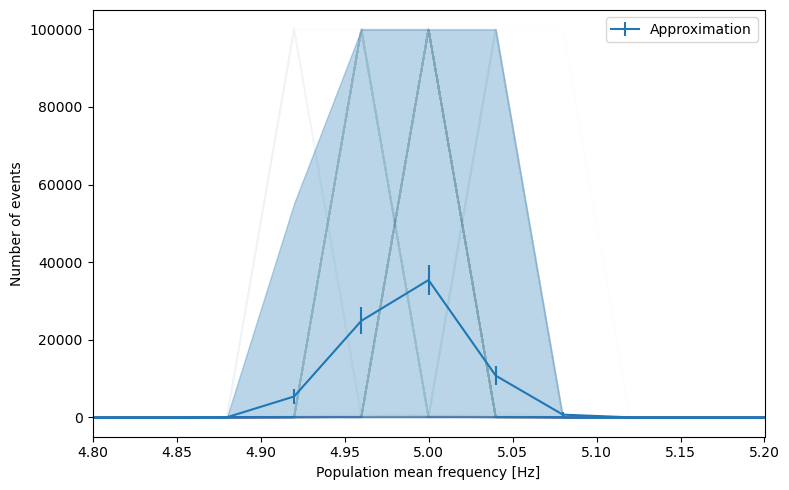

In [12]:
_ = make_plots(
    np.linspace(*config["frequency_evaluation_bounds"], config["plot_points"]),
    *np.maximum(np.array(all_divs), 1e-5),
    mode="events",
    nevents=config["simulate"]["n_events"],
)